<a href="https://colab.research.google.com/github/slavyolov/Algorithms/blob/main/NAB_datasets_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NAB dataset**
- https://www.kaggle.com/code/anisamand/nab-dsataset-visualisation-with-correct-labels/data
 - Welcome. This repository contains the data and scripts which comprise the Numenta Anomaly Benchmark (NAB) v1.1. NAB is a novel benchmark for evaluating algorithms for anomaly detection in streaming, real-time applications. It is composed of over 50 labeled real-world and artificial timeseries data files plus a novel scoring mechanism designed for real-time applications.
- repo - https://github.com/numenta/NAB
- data - https://github.com/numenta/NAB/tree/master/data
- labels - https://github.com/numenta/NAB/tree/master/labels

In [ ]:
!git clone https://github.com/numenta/NAB.git

Cloning into 'NAB'...
remote: Enumerating objects: 7029, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 7029 (delta 48), reused 58 (delta 35), pack-reused 6915
Receiving objects: 100% (7029/7029), 86.74 MiB | 20.77 MiB/s, done.
Resolving deltas: 100% (4922/4922), done.
Checking out files: 100% (1186/1186), done.


In [ ]:
!ls

NAB  sample_data


In [ ]:
!ls -la NAB/data

total 40
drwxr-xr-x  9 root root 4096 Aug 24 20:50 .
drwxr-xr-x 10 root root 4096 Aug 24 20:50 ..
drwxr-xr-x  2 root root 4096 Aug 24 20:50 artificialNoAnomaly
drwxr-xr-x  2 root root 4096 Aug 24 20:50 artificialWithAnomaly
-rw-r--r--  1 root root 2931 Aug 24 20:50 README.md
drwxr-xr-x  2 root root 4096 Aug 24 20:50 realAdExchange
drwxr-xr-x  2 root root 4096 Aug 24 20:50 realAWSCloudwatch
drwxr-xr-x  2 root root 4096 Aug 24 20:50 realKnownCause
drwxr-xr-x  2 root root 4096 Aug 24 20:50 realTraffic
drwxr-xr-x  2 root root 4096 Aug 24 20:50 realTweets


In [52]:
!pip install adtk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 2.9 MB/s 


In [53]:
# libraries
#%matplotlib notebook
import os
import pandas as pd
import numpy as np
import json

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from adtk.transformer import Retrospect
from sklearn.linear_model import LinearRegression

# **Get data from NAB**

In [ ]:
# Store the data in dictionary - to retrieve use data["sub_folder_name"]["file_name.csv"]
data = {}
path = '/content/NAB/data/'

def addFolderAndReadAll(f_name):
    data[f_name] = {}
    csvs = os.listdir(path + '/' + f_name)
    csvs_num = 0
    for csv in csvs:
        data[f_name][csv] = pd.read_csv(path + '/' + f_name + '/' + csv)
        csvs_num += 1
    return csvs_num

csvs_num = sum([addFolderAndReadAll(f_name) for f_name in os.listdir(path) if os.path.isdir(path + f_name)])
print(f"Number of datasets : {csvs_num}")
print(f"Available sub directories", data.keys())

Number of datasets : 58
Available sub directories dict_keys(['artificialWithAnomaly', 'realTweets', 'realAWSCloudwatch', 'realTraffic', 'artificialNoAnomaly', 'realAdExchange', 'realKnownCause'])


In [ ]:
# Loading anomaly labels and retrieving corresponding indices in the dataset.
with open('/content/NAB/labels/combined_windows.json', 'r') as file:
    labels = json.load(file)



for key1 in data:
    for key2 in data[key1]:
        one_csv_labels = labels[key1+'/'+key2]
        data[key1][key2]['interval'] = np.array(0)
        num = 0
        for interval in one_csv_labels:
            #print(key2, interval, num)
            index1 = list(data[key1][key2]['timestamp']).index(interval[0][:19])
            index2 = list(data[key1][key2]['timestamp']).index(interval[1][:19])
            data[key1][key2]['interval'][num] = slice(index1, index2)
            num += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


# New section

In [ ]:
data['realKnownCause']['nyc_taxi.csv']

timestamp  value                  interval
0      2014-07-01 00:00:00  10844   slice(5839, 6045, None)
1      2014-07-01 00:30:00   8127   slice(7080, 7286, None)
2      2014-07-01 01:00:00   6210   slice(8423, 8629, None)
3      2014-07-01 01:30:00   4656   slice(8731, 8937, None)
4      2014-07-01 02:00:00   3820  slice(9977, 10183, None)
...                    ...    ...                       ...
10315  2015-01-31 21:30:00  24670                         0
10316  2015-01-31 22:00:00  25721                         0
10317  2015-01-31 22:30:00  27309                         0
10318  2015-01-31 23:00:00  26591                         0
10319  2015-01-31 23:30:00  26288                         0

[10320 rows x 3 columns]


# **1.2 Visualize data and anomalies**

- Blue is normal datapoints. Red is anomaly.


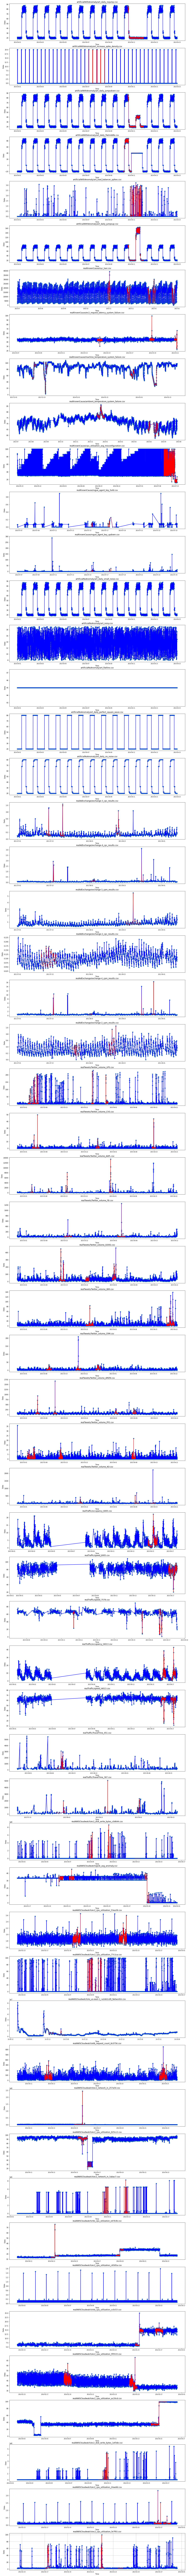

In [ ]:
fig = plt.figure(figsize=(20, 300))

num = 0
for key1 in data:
    for key2 in data[key1]:
        
        num += 1
        y = data[key1][key2]['value']
        x = pd.to_datetime(data[key1][key2]['timestamp'])
        
        ax = fig.add_subplot(csvs_num,1,num)
        
        ax.title.set_text(key1+'/'+key2)
        ax.set_xlabel('Time')
        ax.set_ylabel('Data')
        plt.setp(ax.get_xticklabels(), size=8)
        ax.plot(x, y, 'b-', linewidth=2)
        i = 0
        while data[key1][key2]['interval'][i] != 0:
            bold = data[key1][key2]['interval'][i]
            ax.plot(x[bold], y[bold], 'r-', linewidth=1)
            i += 1
        ax.scatter(x, y)

plt.grid()
plt.show()


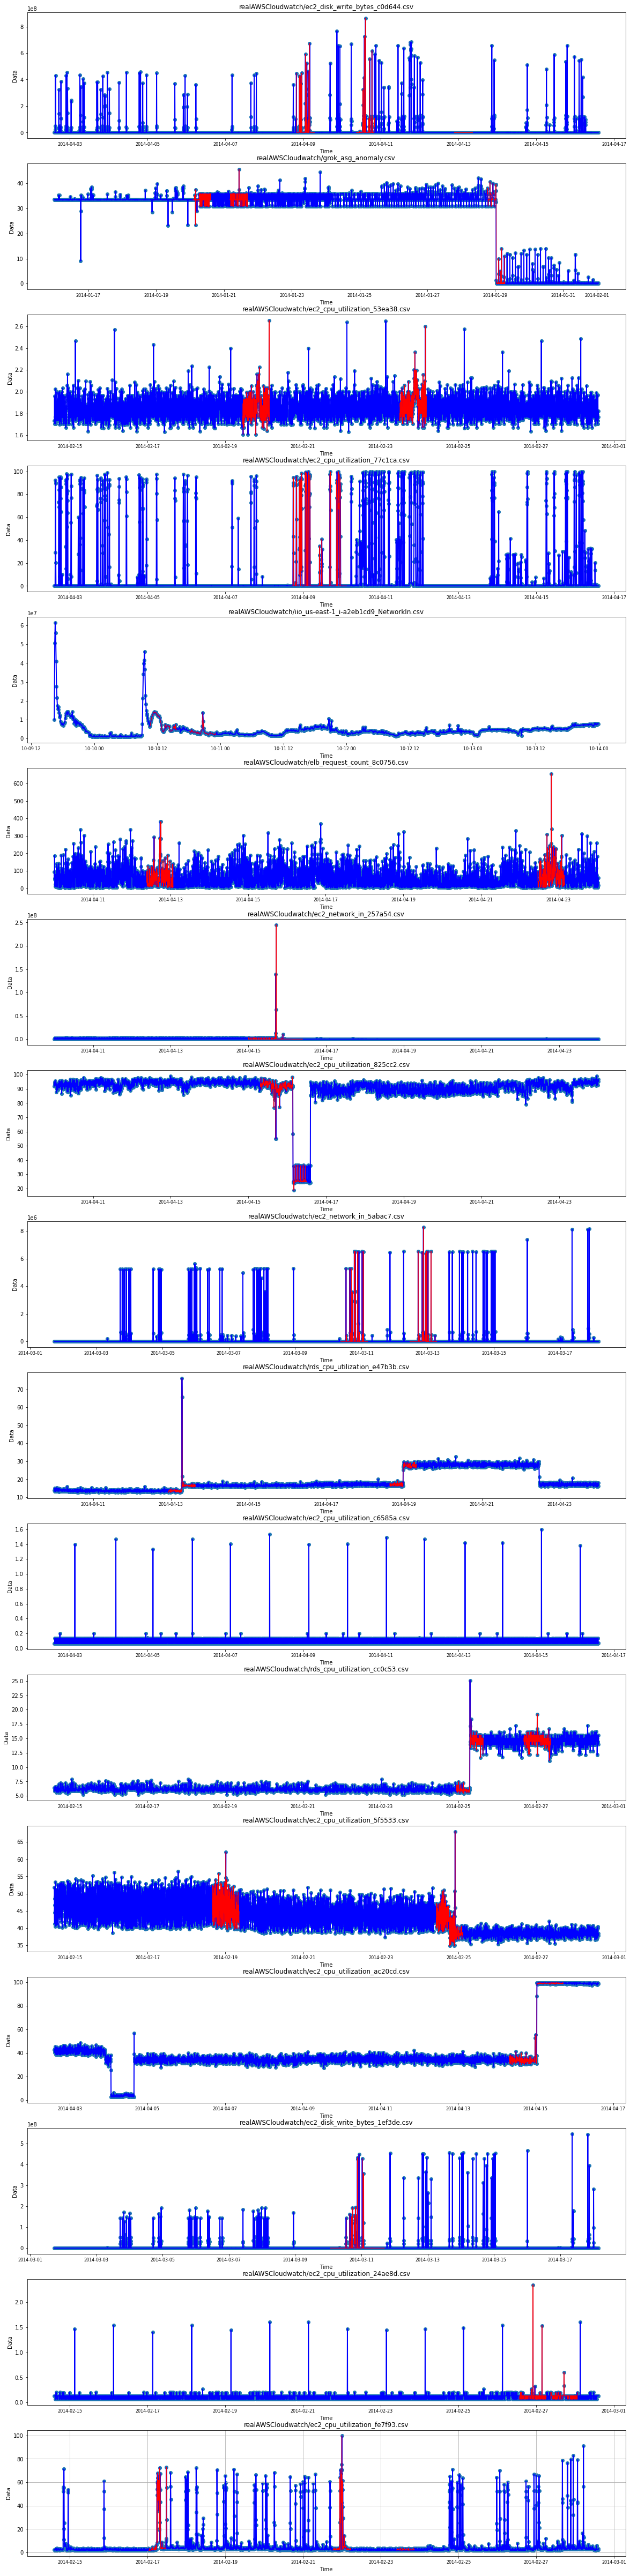

dict_keys(['artificialWithAnomaly', 'realKnownCause', 'artificialNoAnomaly', 'realAdExchange', 'realTweets', 'realTraffic', 'realAWSCloudwatch'])


In [ ]:
fig = plt.figure(figsize=(20, 300))

num = 0
for key1 in data:
    if key1 == 'realAWSCloudwatch':
        for key2 in data[key1]:
            
            num += 1
            y = data[key1][key2]['value']
            x = pd.to_datetime(data[key1][key2]['timestamp'])
            
            ax = fig.add_subplot(csvs_num,1,num)
            
            ax.title.set_text(key1+'/'+key2)
            ax.set_xlabel('Time')
            ax.set_ylabel('Data')
            plt.setp(ax.get_xticklabels(), size=8)
            ax.plot(x, y, 'b-', linewidth=2)
            i = 0
            while data[key1][key2]['interval'][i] != 0:
                bold = data[key1][key2]['interval'][i]
                ax.plot(x[bold], y[bold], 'r-', linewidth=1)
                i += 1
            ax.scatter(x, y)

plt.grid()
plt.show()

print(data.keys())

# **Data in focus - /content/NAB/data/realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv**

In [38]:
# Load single file

input_data = data["realAWSCloudwatch"]["ec2_cpu_utilization_825cc2.csv"].copy(deep=True)
input_data = input_data.drop('interval', axis=1)
input_data = input_data.rename(columns={'value': 'y'})
input_data.head(3)

# Load the anomaly ranges for the file
anomaly_ranges = labels["realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv"] # start, end ranges of the anomalies
input_data['anomaly'] = 0
for start, end in anomaly_ranges:
    input_data.loc[((input_data['timestamp'] >= start) & (input_data['timestamp'] <= end)), 'anomaly'] = 1

print("COUNT of anomalies :\n\n", input_data.groupby('anomaly')['anomaly'].count())
print()
input_data.head(2)

COUNT of anomalies :

 anomaly
0    3690
1     342
Name: anomaly, dtype: int64



timestamp       y  anomaly
0  2014-04-10 00:04:00  91.958        0
1  2014-04-10 00:09:00  94.798        0

In [ ]:
# Scale the data
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
input_data_scaled = input_data.copy(deep=True)
input_data_scaled["y"] = scaler.fit_transform(input_data_scaled["y"].values.reshape(-1, 1))
input_data_scaled.head(2)

timestamp         y  anomaly
0  2014-04-10 00:04:00 -0.094088        0
1  2014-04-10 00:09:00  0.450129        0

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
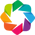

:Overlay
   .Curve.CPU             :Curve   [index]   (y)
   .Points.Anomaly_Points :Points   [x,y]

In [ ]:
# Plot data and anomalies
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')


anomalies = [[ind, value] for ind, value in zip(input_data_scaled[input_data_scaled['anomaly']==1].index, input_data_scaled.loc[input_data_scaled['anomaly']==1,'y'])]
(hv.Curve(input_data_scaled['y'], label="CPU") * hv.Points(anomalies, label="Anomaly Points").opts(color='red', legend_position='bottom', size=2, title="CPU & Anomaly Points"))\
    .opts(opts.Curve(xlabel="Time", ylabel="CPU", width=700, height=400,tools=['hover'],show_grid=True))

In [ ]:
train_fraction = 0.5

train_size = int(len(input_data_scaled) * train_fraction)
train, test = input_data_scaled[0:train_size], input_data_scaled[train_size:len(input_data_scaled)]

print("COUNT of anomalies in TRAIN dataset :\n\n", train.groupby('anomaly')['anomaly'].count())
print("COUNT of anomalies in TEST dataset:\n\n", test.groupby('anomaly')['anomaly'].count())

COUNT of anomalies in TRAIN dataset :

 anomaly
0    1674
1     342
Name: anomaly, dtype: int64
COUNT of anomalies in TEST dataset:

 anomaly
0    2016
Name: anomaly, dtype: int64


# **Feature processing**

### **Statistical features**

In [ ]:
stats_window = 10

# Train
x_stats = pd.DataFrame(
    data={
        "mean": train['y'].rolling(stats_window).mean().values.reshape(-1),
        "std": train['y'].rolling(stats_window).std().values.reshape(-1),
        "median": train['y'].rolling(stats_window).median().values.reshape(-1),
    },
    index=train['y'].rolling(stats_window).mean().index,
)
x_stats = x_stats.iloc[stats_window :]
x_stats

mean       std    median
10    0.280004  0.222590  0.290505
11    0.240759  0.223855  0.178787
12    0.282303  0.202188  0.290505
13    0.264482  0.213483  0.225352
14    0.238114  0.247723  0.217304
...        ...       ...       ...
2011 -0.658618  0.433745 -0.717448
2012 -0.729520  0.490119 -0.772636
2013 -0.742857  0.486707 -0.772636
2014 -0.793983  0.405955 -0.772636
2015 -0.678203  0.575340 -0.772636

[2006 rows x 3 columns]

In [ ]:
!pip install adtk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 6.2 MB/s 


In [ ]:
train

timestamp         y  anomaly
0     2014-04-10 00:04:00 -0.094088        0
1     2014-04-10 00:09:00  0.450129        0
2     2014-04-10 00:14:00 -0.046182        0
3     2014-04-10 00:19:00  0.243940        0
4     2014-04-10 00:24:00  0.113634        0
...                   ...       ...      ...
2011  2014-04-16 23:49:00 -0.780492        0
2012  2014-04-16 23:54:00 -1.379132        0
2013  2014-04-16 23:59:00 -0.690428        0
2014  2014-04-17 00:04:00 -0.389576        0
2015  2014-04-17 00:09:00  0.488838        0

[2016 rows x 3 columns]

In [ ]:
ts = pd.Series(train['y'].values, index=train['timestamp'])
ts

timestamp
2014-04-10 00:04:00   -0.094088
2014-04-10 00:09:00    0.450129
2014-04-10 00:14:00   -0.046182
2014-04-10 00:19:00    0.243940
2014-04-10 00:24:00    0.113634
                         ...   
2014-04-16 23:49:00   -0.780492
2014-04-16 23:54:00   -1.379132
2014-04-16 23:59:00   -0.690428
2014-04-17 00:04:00   -0.389576
2014-04-17 00:09:00    0.488838
Length: 2016, dtype: float64

x_retrospective                           t-0       t-1       t-2
timestamp                                        
2014-04-10 00:19:00  0.243940 -0.046182  0.450129
2014-04-10 00:24:00  0.113634  0.243940 -0.046182
2014-04-10 00:29:00  0.097538  0.113634  0.243940
2014-04-10 00:34:00  0.624509  0.097538  0.113634
2014-04-10 00:39:00  0.536744  0.624509  0.097538


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


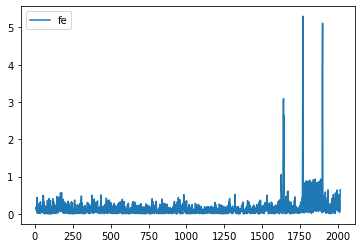

In [ ]:
from adtk.transformer import Retrospect
from sklearn.linear_model import LinearRegression


forecast_model = LinearRegression()
fe_nsteps = 3
fe_step_size = 1
forecasting_horizon = 3
frac = 1 


# create time series object
train_ts = 5
train_ts = pd.Series(train['y'].values, index=pd.DatetimeIndex(train['timestamp']))
# train_ts = train_ts.resample(f"{sampling_interval}min").backfill()

# Transformer that returns dataframe with retrospective values (lags of y)
x_retrospective = Retrospect(n_steps=fe_nsteps, step_size=fe_step_size, till=0).transform(train_ts)
x_retrospective = x_retrospective.iloc[fe_nsteps * fe_step_size :]
# x_retrospective = x_retrospective.reset_index()
print("x_retrospective", x_retrospective.head(5))

y = x_retrospective["t-0"]
x = x_retrospective[
    ["t-" + str(i) for i in range(fe_step_size, fe_nsteps * fe_step_size, fe_step_size)]
]

x_train = x.values[: int(frac * len(x))]
y_train = y.values[: int(frac * len(x))]

# Train model
forecast_model.fit(x_train, y_train)

# Prediction - in sample
window_len = forecasting_horizon
one_step_ahead_predictions = forecast_model.predict(x)

def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


one_step_ahead_predictions_diff_targets = one_step_ahead_predictions - y

windows_arr = rolling_window(one_step_ahead_predictions_diff_targets.values, window_len)
x_rolling_rmse_scores = np.sqrt(np.mean(windows_arr, axis=1) ** 2)[1:]


x_rolling_rmse_scores_df = pd.DataFrame(
                {"fe": x_rolling_rmse_scores},
                index=train.iloc[forecasting_horizon + (fe_nsteps * fe_step_size) :].index,
            )
        
x_rolling_rmse_scores_df.plot()

In [ ]:
rmse_avg_model_1 = x_rolling_rmse_scores_df.mean()

print(rmse_avg_model_1)

fe    0.156698
dtype: float64


x_retrospective                           t-0       t-1       t-2
timestamp                                        
2014-04-17 00:25:00 -1.283702 -0.700776 -0.157708
2014-04-17 00:30:00 -0.667050 -1.283702 -0.700776
2014-04-17 00:35:00 -1.084028 -0.667050 -1.283702
2014-04-17 00:40:00 -1.315512 -1.084028 -0.667050
2014-04-17 00:45:00 -0.732969 -1.315512 -1.084028


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


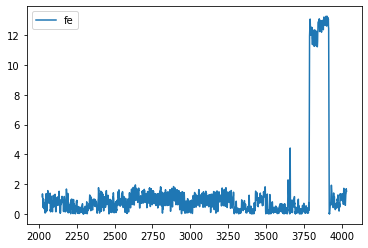

In [ ]:
### Out of sample :

# create time series object
sampling_interval = 5
test_ts = pd.Series(test['y'].values, index=pd.DatetimeIndex(test['timestamp']))
test_ts = test_ts.resample(f"{sampling_interval}min").backfill()

# # Transformer that returns dataframe with retrospective values (lags of y)
x_retrospective = Retrospect(n_steps=fe_nsteps, step_size=fe_step_size, till=0).transform(test_ts)
x_retrospective = x_retrospective.iloc[fe_nsteps * fe_step_size :]
# x_retrospective = x_retrospective.reset_index()
print("x_retrospective", x_retrospective.head(5))

y = x_retrospective["t-0"]
x = x_retrospective[
    ["t-" + str(i) for i in range(fe_step_size, fe_nsteps * fe_step_size, fe_step_size)]
]

x_test = x.values[: int(frac * len(x))]
y_test = y.values[: int(frac * len(x))]

one_step_ahead_predictions_test = forecast_model.predict(x)


# Prediction - out of sample
window_len = forecasting_horizon
one_step_ahead_predictions_test = forecast_model.predict(x)

def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


one_step_ahead_predictions_diff_targets_test = one_step_ahead_predictions - y

windows_arr = rolling_window(one_step_ahead_predictions_diff_targets_test.values, window_len)
x_rolling_rmse_scores = np.sqrt(np.mean(windows_arr, axis=1) ** 2)[1:]


x_rolling_rmse_scores_df_test = pd.DataFrame(
                {"fe": x_rolling_rmse_scores},
                index=test.iloc[forecasting_horizon + (fe_nsteps * fe_step_size) :].index,
            )
        
x_rolling_rmse_scores_df_test.plot()

In [ ]:
rmse_avg_model_1 = x_rolling_rmse_scores_df.mean()
rmse_avg_model_1_test = x_rolling_rmse_scores_df_test.mean()

print(rmse_avg_model_1)
print(rmse_avg_model_1_test)

fe    0.156698
dtype: float64
fe    1.523196
dtype: float64


# **Autoregressive models (AR)**

## Key points
- Autoregressive (AR) models are a subset of time series models, which can be used to predict future values based on previous observations. 
- AR models use regression techniques and rely on **`autocorrelation`** in order to make accurate predictions. 
- autoregressive modeling will mean creating the model where the response variable Y will depend upon the **`previous values of Y`** at a pre-determined **`constant time lag`**

## TODOs when doing the AR model
- **Stationarity of the time-series data**: The stationarity of the data can be found using adfuller class of statsmodels.tsa.stattools module. The value of p-value is used to determine whether there is stationarity. If the value is less than 0.05, the stationarity exists.
- **Order of AR model to be trained**: The order of AR model is determined by checking the `partial autocorrelation plot`. The plot_pacf method of statsmodels.graphics.tsaplots is used to plot. 
  - How to read the `partial autocorrelation plot` a https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/

## Other readings :
- https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

## predicting : 
- retrain the model (if not computationally expesive)
- An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of N prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts.

         Date  Consumption  Wind  Solar  Wind+Solar
0  2006-01-01     1069.184   NaN    NaN         NaN
1  2006-01-02     1380.521   NaN    NaN         NaN
2  2006-01-03     1442.533   NaN    NaN         NaN
3  2006-01-04     1457.217   NaN    NaN         NaN
4  2006-01-05     1477.131   NaN    NaN         NaN


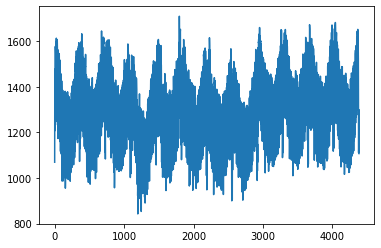

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load AutoReg class from statsmodels.tsa.ar_model module
from statsmodels.tsa.ar_model import AutoReg

# Load and plot the time-series data
url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
df = pd.read_csv(url,sep=",")
print(df.head())
df['Consumption'].plot()

In [26]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
from statsmodels.tsa.stattools import adfuller

# Run the test
df_stationarity_test = adfuller(df['Consumption'], autolag='AIC')

# Check the value of p-value
if df_stationarity_test[1] < 0.05:
    print("stationarity of the data exists, p-value is less than 0.05")
else:
    print("stationarity does not exist, p-value is greater or equal than 0.05")

print("P-value: ", df_stationarity_test[1])

stationarity of the data exists, p-value is less than 0.05
P-value:  4.7440549018425884e-08


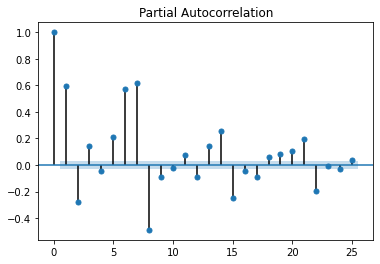

In [27]:
# Next step is to find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data

from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(df['Consumption'], lags=25)

In [28]:
# Create training and test data
train_data = df['Consumption'][:len(df)-100]
test_data = df['Consumption'][len(df)-100:]

# Instantiate and fit the AR model with training data
ar_model = AutoReg(train_data, lags=8).fit()

# Print Summary
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:            Consumption   No. Observations:                 4283
Model:                     AutoReg(8)   Log Likelihood              -24231.812
Method:               Conditional MLE   S.D. of innovations             70.058
Date:                Wed, 24 Aug 2022   AIC                              8.503
Time:                        21:37:58   BIC                              8.518
Sample:                             8   HQIC                             8.509
                                 4283                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        121.2792     14.444      8.397      0.000      92.969     149.589
Consumption.L1     0.6393      0.013     47.751      0.000       0.613       0.666
Consumption.L2    -0.0966      0.011

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


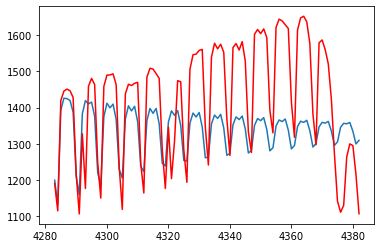

In [37]:
# Make the predictions
pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)

# Plot the prediction vs test data
from matplotlib import pyplot
pyplot.plot(pred)
pyplot.plot(test_data, color='red')

### Example : cpu 

In [47]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
from statsmodels.tsa.stattools import adfuller

# Run the test
df_stationarity_test_cpu = adfuller(input_data['y'], autolag='AIC')

# Check the value of p-value
if df_stationarity_test_cpu[1] < 0.05:
    print("stationarity of the data exists, p-value is less than 0.05")
else:
    print("stationarity does not exist, p-value is greater or equal than 0.05")

print("P-value: ", df_stationarity_test_cpu[1])

stationarity of the data exists, p-value is less than 0.05
P-value:  0.000576151600112687


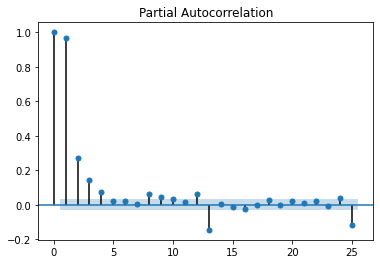

In [49]:
# Next step is to find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data

from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(input_data['y'], lags=25)

# Based on the plot AR(2) is ok

In [97]:
# Train AR model
fe_nsteps = 3 # steps from the plot_pacf + 1
fe_step_size = 1 
forecasting_horizon = 3 # value coming from the paper (Cross-dataset Time Series Anomaly Detection for Cloud Systems)
sampling_interval = 5

# Train/test split keeping the temporal order of the time series
frac = 0.5
train_size = int(len(input_data) * frac)
train_df, test_df = input_data[0:train_size], input_data[train_size:len(input_data)]

def get_retrospective_values(input_data):
    ts = pd.Series(input_data['y'].values, index=pd.DatetimeIndex(input_data['timestamp']))
    ts = ts.resample(f"{sampling_interval}min").backfill()

    x_retrospective = Retrospect(n_steps=fe_nsteps, step_size=fe_step_size, till=0).transform(ts)
    x_retrospective = x_retrospective.iloc[fe_nsteps * fe_step_size :]

    y = x_retrospective["t-0"].values
    x = x_retrospective[
        ["t-" + str(i) for i in range(fe_step_size, fe_nsteps * fe_step_size, fe_step_size)]
    ].values
    return x, y

x_train, y_train = get_retrospective_values(input_data=train_df)
x_test, y_test = get_retrospective_values(input_data=test_df)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# train model
ar_model = LinearRegression()
ar_model = forecast_model.fit(x_train, y_train)

# predictions
one_step_ahead_predictions = ar_model.predict(x_test)
one_step_ahead_predictions_diff_targets = one_step_ahead_predictions - y_test

def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

windows_arr = rolling_window(one_step_ahead_predictions_diff_targets, forecasting_horizon) # take 1st three values (1,2,3) at row 1, at row 2 take (2,3,4) value
x_rolling_rmse_scores = np.sqrt(np.mean(windows_arr, axis=1) ** 2)[1:]

forecast_error_df = pd.DataFrame(
                {"fe": x_rolling_rmse_scores},
                index=test_df.iloc[forecasting_horizon + (fe_nsteps * fe_step_size) :].index
)

(2013, 4)
(2013,)
(2011, 4)
(2011,)


In [94]:
forecast_error_df['fe'].mean()

0.8730529624321062

In [96]:
forecast_error_df['fe'].mean()

0.8981432353617795

In [98]:
forecast_error_df['fe'].mean()

0.8945382070796138